In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%load_ext autoreload
%autoreload 2
from ieee80211phy.transmitter.main import tx_generator
from ieee80211phy.receiver.packet_detector import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_complex64_file(file: str):
    import scipy as sp
    f = sp.fromfile(open(file), dtype=sp.complex64)
    return f

f = load_complex64_file('/home/gaspar/rx_wire_lowpower')

<IPython.core.display.Javascript object>


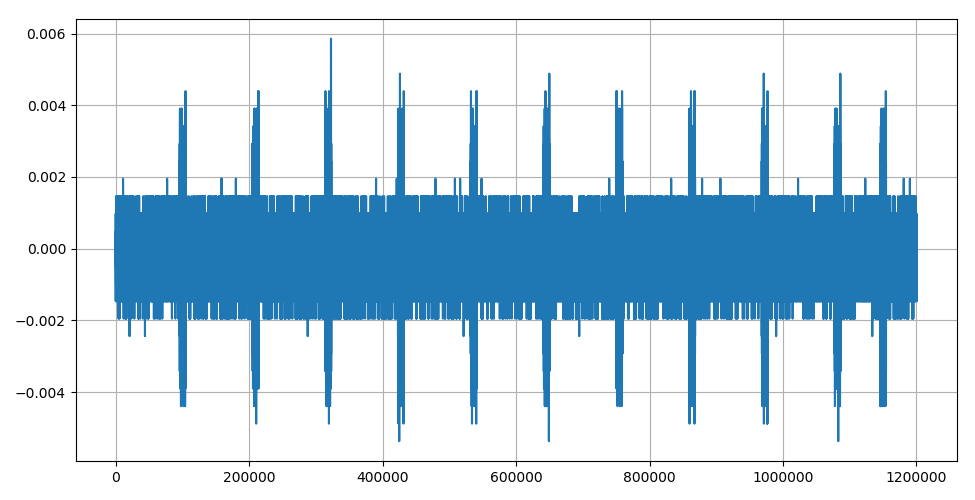

/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [18]:
input = f[1000000:2200000]
plt.figure(figsize=(9.75,5))
plt.plot(input)
plt.tight_layout()
plt.grid()

/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


<IPython.core.display.Javascript object>


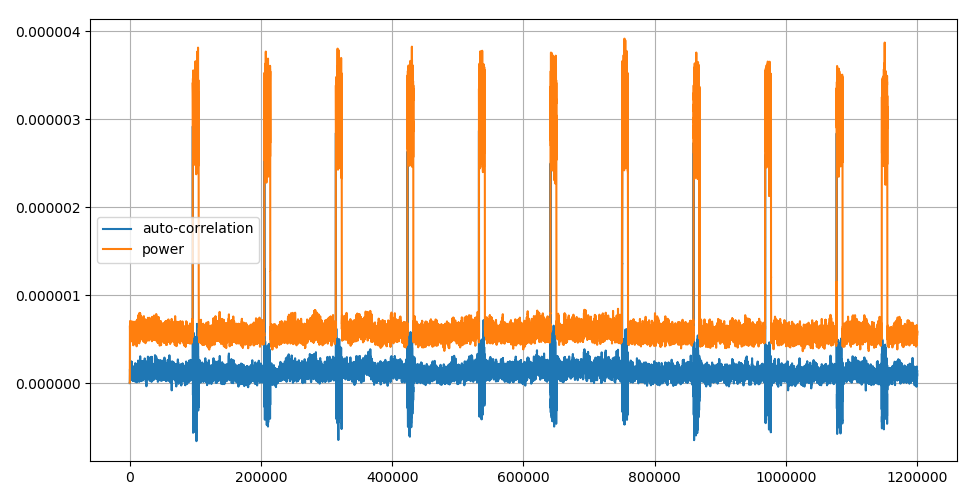

<IPython.core.display.Javascript object>


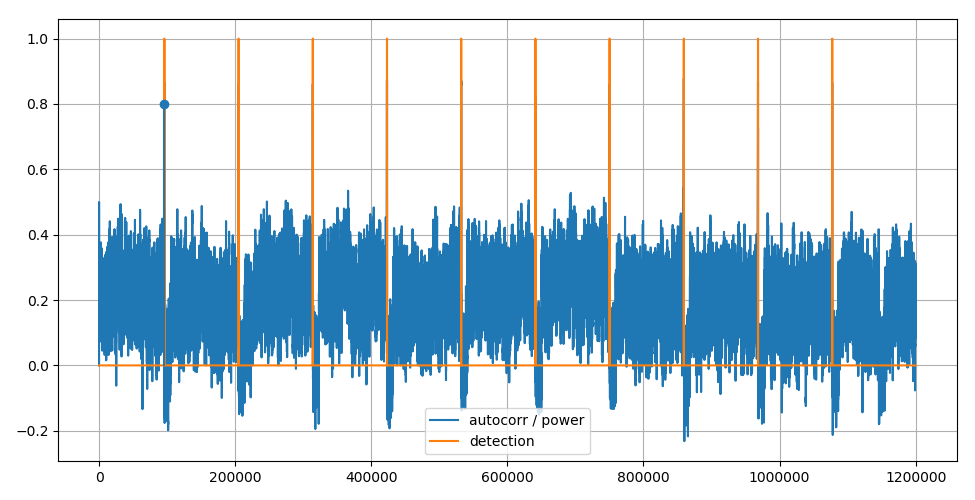

95998

In [19]:
packet_detector(input, debug=True)

/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


<IPython.core.display.Javascript object>


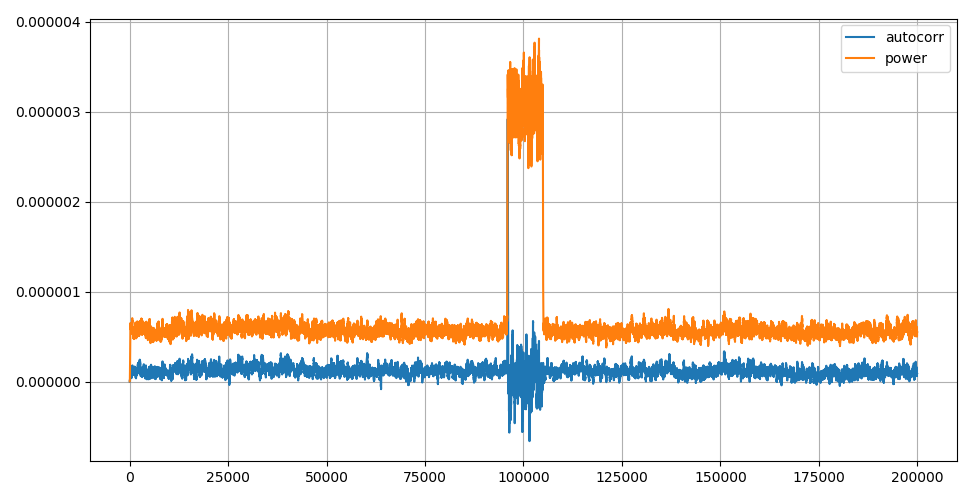

<IPython.core.display.Javascript object>


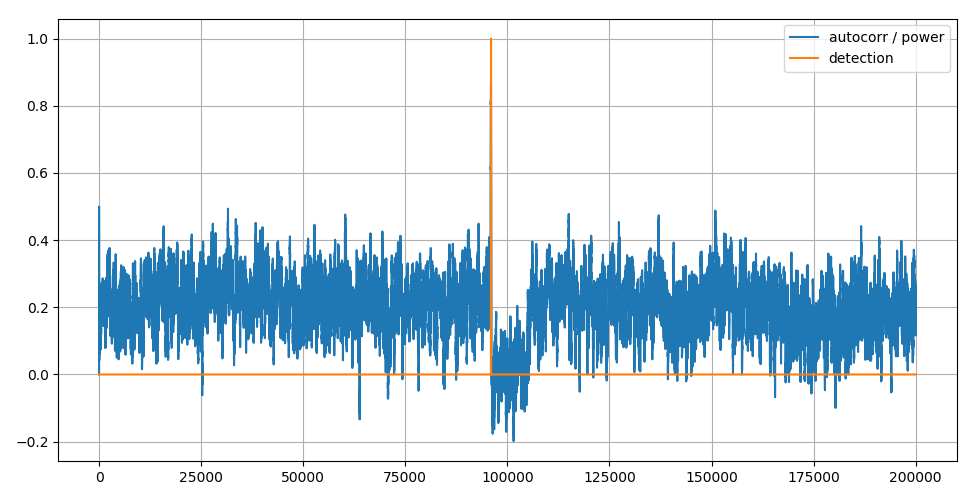

Falling edge position:  95990


In [10]:

def average(inputs, window_len):
    taps = [1 / window_len] * window_len
    return signal.lfilter(taps, [1.0], inputs)

# mult = input[:-16] * np.conjugate(input[16:])
# avg = average(mult, 64)
# avg = average(avg, 64)
# autocorr = avg.real

# tmp = (input * np.conjugate(input)).real
# avg = average(tmp, 64)
# avg = average(avg, 64)
# power = avg

mult = input[:-16] * np.conjugate(input[16:])
avg = average(mult, 128)
autocorr = avg.real

tmp = (input * np.conjugate(input)).real
avg = average(tmp, 128)
power = avg

plt.figure(figsize=(9.75,5))
plt.plot(autocorr, label='autocorr')
plt.plot(power, label='power')
plt.legend()
plt.tight_layout()
plt.grid()


ratio = np.array(autocorr / power[:len(autocorr)])

detection = 0
det = []
for i in range(len(ratio)):
    if ratio[i] > 0.85:
        detection = 1
    elif ratio[i] < 0.85:
        detection = 0
    det.append(detection)

plt.figure(figsize=(9.75,5))
plt.plot(ratio, label='autocorr / power')
plt.plot(det, label='detection')
plt.legend()
plt.tight_layout()
plt.grid()

falling_edge_i = np.where(np.diff(det) == -1)[0][0]
print('Falling edge position: ', falling_edge_i)

Coarse freq error is -92239.7610315208
63733.55263157895


/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


<IPython.core.display.Javascript object>


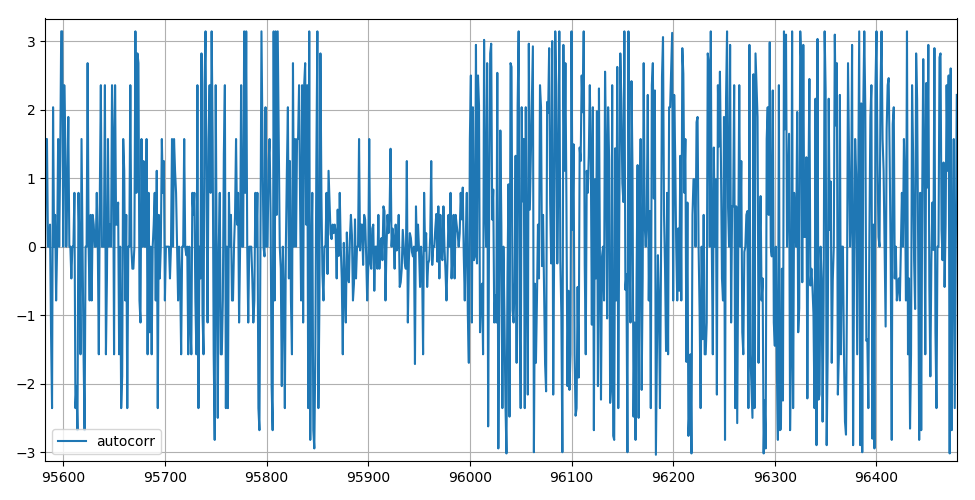

In [9]:
from ieee80211phy.util import *
mult = input[:-16] * np.conjugate(input[16:])
avg = moving_average(mult, 1)
angle = np.angle(avg)

freq_error = angle * (20e6/(2*np.pi*16))
print(f'Coarse freq error is {freq_error[falling_edge_i-50]}')
avg = np.mean(freq_error[64:140])
print(avg)

plt.figure(figsize=(9.75,5))
plt.plot(angle, label='autocorr')
# plt.plot(freq_error, label='freq_err')
plt.stem([50], [1.0])
plt.legend()
plt.tight_layout()
plt.grid()

96109


/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/usr/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


<IPython.core.display.Javascript object>


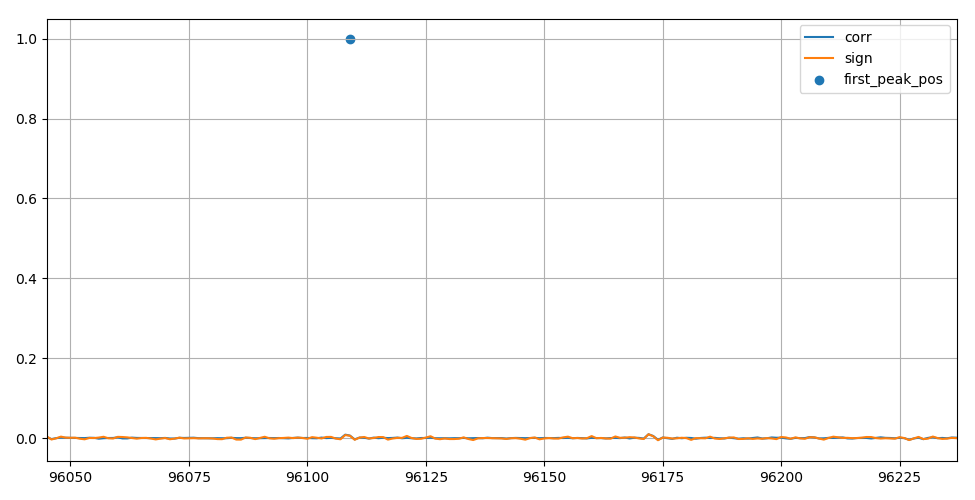

/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


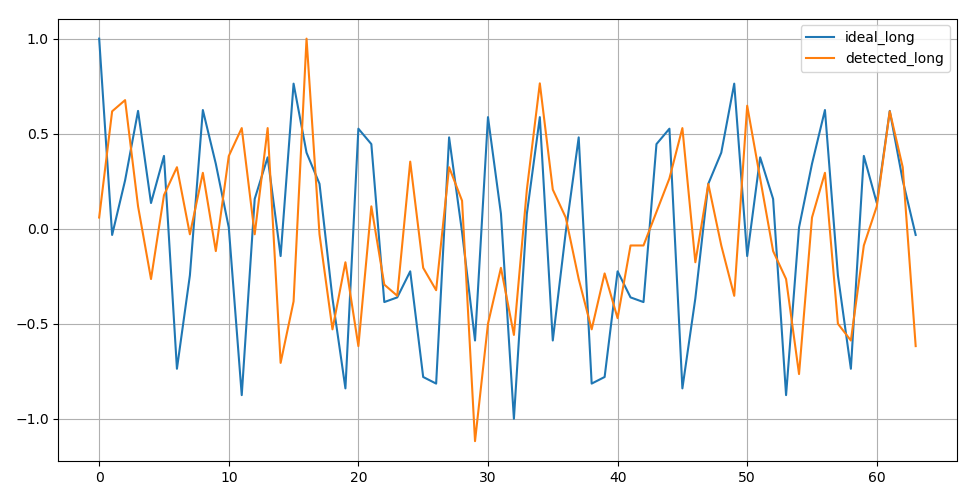

In [22]:
from ieee80211phy.transmitter.preamble import long_train_symbol
import scipy
long_symbol = np.array(long_train_symbol())
corr = scipy.signal.correlate(input, long_symbol)
corr_sign = scipy.signal.correlate(input, np.sign(long_symbol))
corr_sign /= corr_sign.max() / corr.max()

# skip over the first 'halfpeak' - whcih is from guard interval!
long_training_peak = np.argmax(corr[falling_edge_i+54: falling_edge_i+54+64]) + falling_edge_i+54 + 1
print(long_training_peak)

plt.figure(figsize=(9.75,5))
plt.plot(corr, label='corr')
plt.plot(corr_sign, label='sign')
plt.scatter([long_training_peak], [1.0], label='first_peak_pos')
plt.xlim([long_training_peak-64, long_training_peak+128])
# plt.xlim([0, 500])
plt.legend()
plt.tight_layout()
plt.grid()


plt.figure(figsize=(9.75,5))
plt.plot(long_symbol / long_symbol.max(), label='ideal_long')
long = input[long_training_peak-64:long_training_peak]
plt.plot(long / long.max(), label='detected_long')
plt.legend()
plt.tight_layout()
plt.grid()


In [8]:
sample_advance = 0
rx = input[long_training_peak-64-sample_advance:]

# Equalizer

<IPython.core.display.Javascript object>


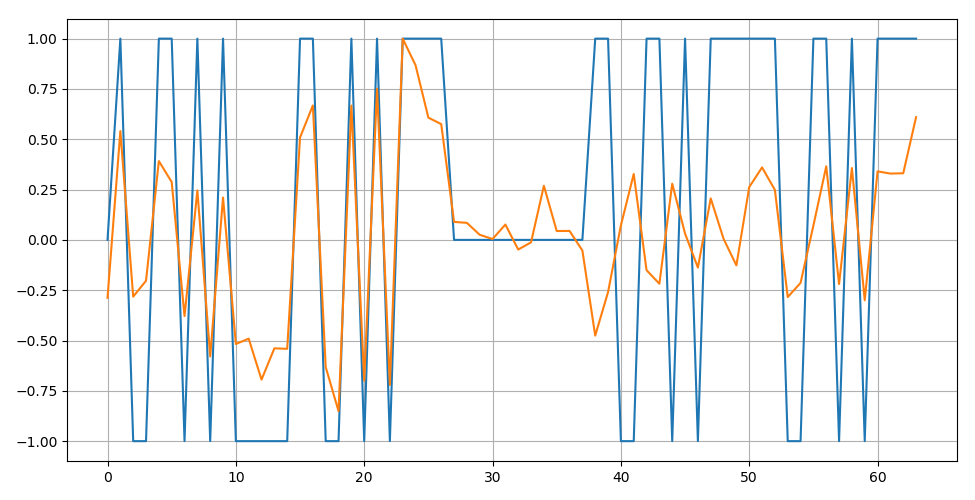

[ 7.49400542e-16+2.85996462e-15j  1.00000000e+00-1.86943752e-15j
 -1.00000000e+00-1.07438822e-15j -1.00000000e+00+2.96870626e-15j
  1.00000000e+00+2.48526435e-15j  1.00000000e+00-5.10122735e-15j
 -1.00000000e+00-3.04503409e-15j  1.00000000e+00-4.87434625e-15j
 -1.00000000e+00+2.06210546e-15j  1.00000000e+00+1.44214960e-15j
 -1.00000000e+00+3.67181521e-15j -1.00000000e+00+1.28949393e-15j
 -1.00000000e+00+4.10896552e-15j -1.00000000e+00+7.72184858e-15j
 -1.00000000e+00+7.75188482e-15j  1.00000000e+00-3.92161539e-15j
  1.00000000e+00-2.17767235e-15j -1.00000000e+00+6.05824877e-15j
 -1.00000000e+00+1.00727995e-15j  1.00000000e+00-2.37062725e-16j
 -1.00000000e+00+3.15139816e-15j  1.00000000e+00-3.55023922e-16j
 -1.00000000e+00+3.19997042e-15j  1.00000000e+00-5.99175908e-15j
  1.00000000e+00-6.73541372e-15j  1.00000000e+00-4.55305473e-15j
  1.00000000e+00-4.62710190e-15j  5.10702591e-15-2.40199762e-15j
  6.66133815e-16-4.01315514e-16j  8.04911693e-15+3.38865469e-16j
  1.49880108e-15+6.169817

/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


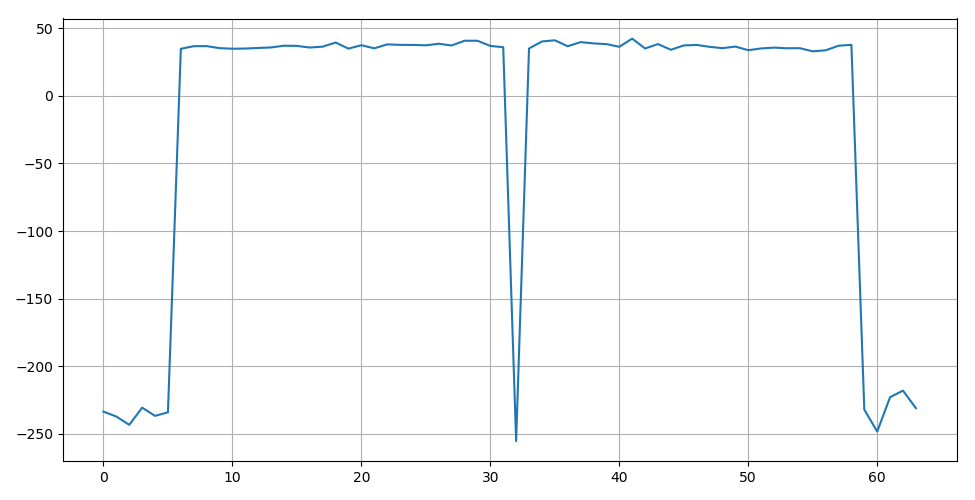

<IPython.core.display.Javascript object>


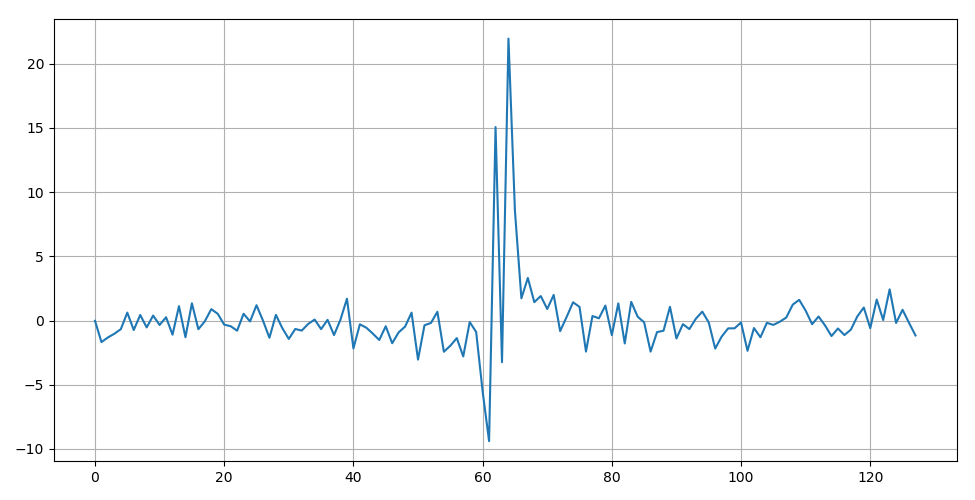

In [19]:
from ieee80211phy.transmitter.preamble import *
ideal_long = long_train_symbol()
first_long_train = rx[:64]
second_long_train = rx[64:64+64]
avg_long_train = (first_long_train + second_long_train) / 2
freq = np.fft.fft(avg_long_train)
ideal_freq = np.fft.fft(ideal_long)

plt.figure(figsize=(9.75,5))
plt.plot(ideal_freq)
plt.plot(freq / freq.max())
plt.tight_layout()
plt.grid()

print(np.fft.fft(ideal_long))
# ideal_freq  [0, 0, 0, 0, 0, 0, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1,
#                   1,
#                   0,
#                   1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 0, 0, 0, 0,
#                   0]

channel_estimate = freq / (np.fft.fft(ideal_long))
equalizer_coefs = 1/channel_estimate



plt.figure(figsize=(9.75,5))
# plt.ylim([-6, 2])
plt.plot()
plt.plot(np.fft.fftshift(20*np.log10(np.abs(equalizer_coefs))))
# plt.plot(equalizer_coefs)
# plt.plot(first_long_train)
# plt.plot(second_long_train)
# plt.plot(avg_long_train)
plt.tight_layout()
plt.grid()

plt.figure(figsize=(9.75,5))
plt.plot(np.fft.fftshift(np.fft.ifft(equalizer_coefs, 128)))
plt.tight_layout()
plt.grid()

# RX

Symbols: 109 Padding: 0


<IPython.core.display.Javascript object>


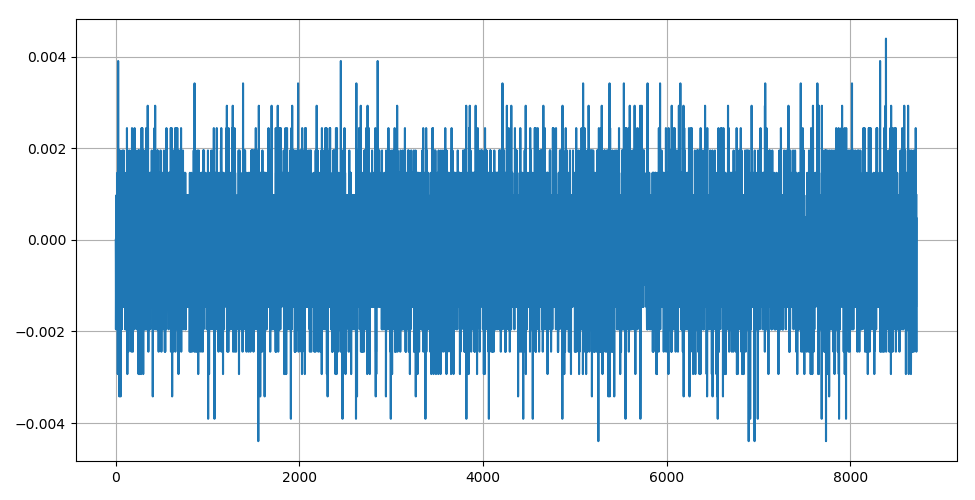

/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [15]:
np.random.seed(0)
data = ''.join('1' if x else '0' for x in np.random.randint(2, size=20906))
tx, maps, ofdm_syms = tx_generator(data, data_rate=36)
from ieee80211phy.transmitter.ofdm_modulation import *

no_head = rx[128:128 + (109*80)]

plt.figure(figsize=(9.75,5))
plt.plot(no_head)
plt.tight_layout()
plt.grid()

symbols = np.reshape(no_head, (-1, 80))
freq = [np.fft.fft(x[16:]) for x in symbols]

equalized = freq
# print(equalizer_coefs)
equalized = [x * equalizer_coefs for x in freq]
symbols = np.array([demap_from_carriers(x) for x in equalized])

symbols_flat = symbols.flatten()


<IPython.core.display.Javascript object>


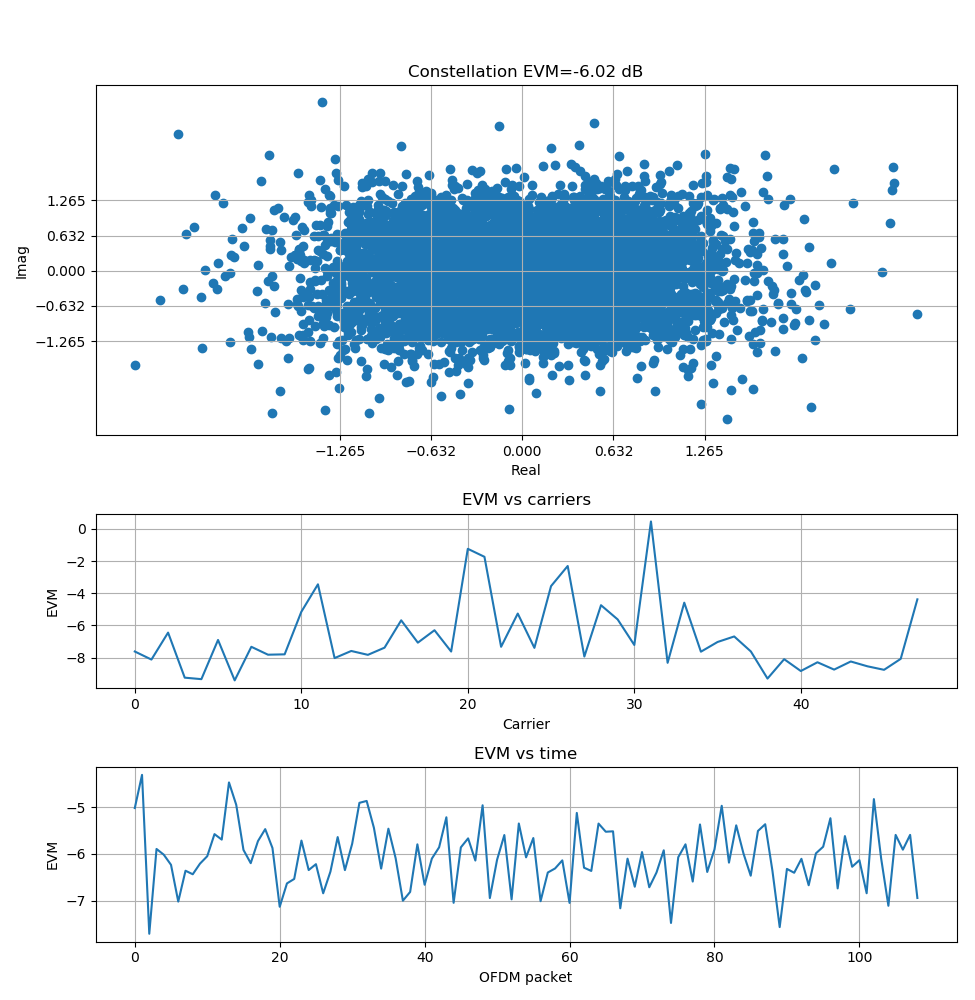

In [16]:
from ieee80211phy.util import *
plot_rx(symbols, ofdm_syms)

<IPython.core.display.Javascript object>


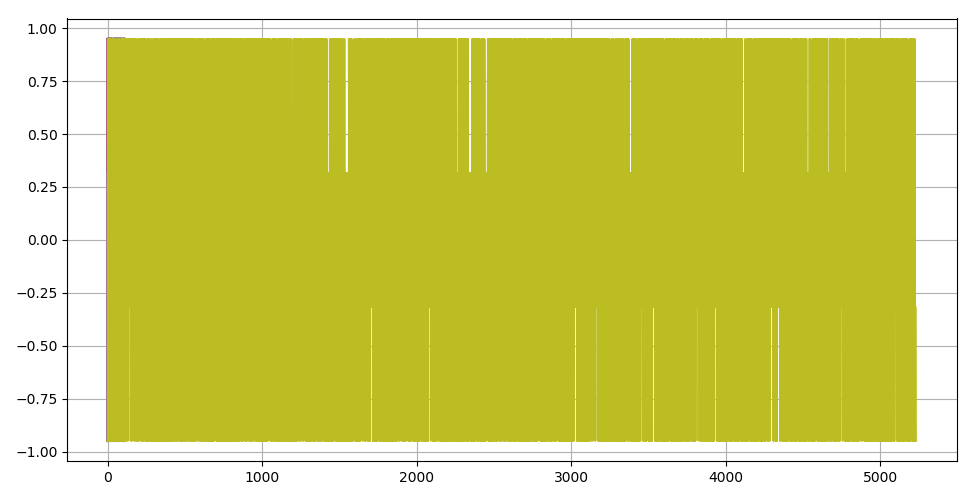

/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [211]:
plt.figure(figsize=(9.75,5))
plt.plot(symbols)
plt.plot(maps)
plt.tight_layout()
plt.grid()

[-1.08012345-1.08012345j -1.08012345-0.77151675j -1.08012345-0.15430335j
 -1.08012345-0.46291005j -1.08012345+1.08012345j -1.08012345+0.77151675j
 -1.08012345+0.15430335j -1.08012345+0.46291005j -0.77151675-1.08012345j
 -0.77151675-0.77151675j -0.77151675-0.15430335j -0.77151675-0.46291005j
 -0.77151675+1.08012345j -0.77151675+0.77151675j -0.77151675+0.15430335j
 -0.77151675+0.46291005j -0.15430335-1.08012345j -0.15430335-0.77151675j
 -0.15430335-0.15430335j -0.15430335-0.46291005j -0.15430335+1.08012345j
 -0.15430335+0.77151675j -0.15430335+0.15430335j -0.15430335+0.46291005j
 -0.46291005-1.08012345j -0.46291005-0.77151675j -0.46291005-0.15430335j
 -0.46291005-0.46291005j -0.46291005+1.08012345j -0.46291005+0.77151675j
 -0.46291005+0.15430335j -0.46291005+0.46291005j  1.08012345-1.08012345j
  1.08012345-0.77151675j  1.08012345-0.15430335j  1.08012345-0.46291005j
  1.08012345+1.08012345j  1.08012345+0.77151675j  1.08012345+0.15430335j
  1.08012345+0.46291005j  0.77151675-1.08012345j  0

<IPython.core.display.Javascript object>


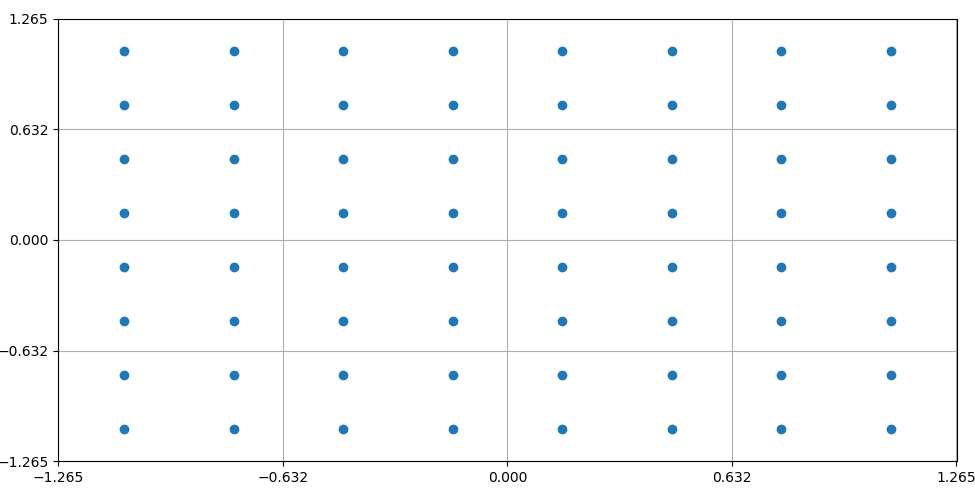

In [250]:
from ieee80211phy.transmitter.subcarrier_modulation_mapping import *
# symbols = np.array([QAM16_LUT_NORM[i>>2] + QAM16_LUT_NORM[i&3] * 1j for i in range(16)])
symbols = np.array([QAM64_LUT_NORM[i>>3] + QAM64_LUT_NORM[i&7] * 1j for i in range(64)])
print(symbols)
pwr = [power(x) for x in symbols]
print(pwr, np.mean(pwr))

plt.figure(figsize=(9.75,5))
plt.scatter(symbols.real, symbols.imag)
plt.tight_layout()
tick_base = 1 / np.sqrt(10)
plt.xticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
plt.yticks([-4*tick_base, -2*tick_base, 0, tick_base*2, tick_base*4])
plt.grid()